In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

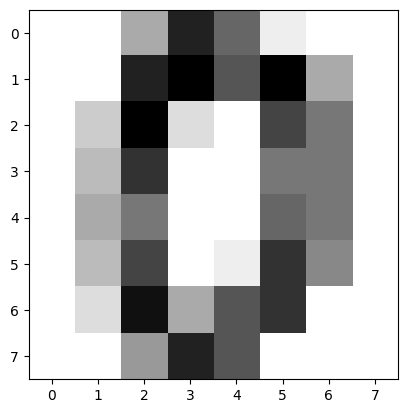

In [2]:
#데이터 확인
digits = datasets.load_digits()
plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')

In [3]:
#데이터 평탄화
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
data.shape

(1797, 64)

In [4]:
#훈련, 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.2)

In [14]:
#pytorch 텐서로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

C:\Users\송이두\AppData\Local\Temp\ipykernel_27972\3742484122.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
C:\Users\송이두\AppData\Local\Temp\ipykernel_27972\3742484122.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)
C:\Users\송이두\AppData\Local\Temp\ipykernel_27972\3742484122.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
C:\Users\송이두\AppData\Local\Temp\ipykernel_27972\374248412

In [6]:
#텐서 데이터셋 설정 및 데이터 로더 설정
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1437, 64]),
 torch.Size([360, 64]),
 torch.Size([1437]),
 torch.Size([360]))

## 모델 정의

In [8]:
class MnistClf(nn.Module):
    def __init__(self):
        super(MnistClf, self).__init__()
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)  

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model, loss function, and optimizer
model = MnistClf()

In [17]:
summary(model, input_size=(64,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           8,320
            Linear-2                  [-1, 128]          16,512
            Linear-3                   [-1, 64]           8,256
            Linear-4                   [-1, 10]             650
Total params: 33,738
Trainable params: 33,738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.13
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## 모델 학습

In [15]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        labels = labels.long()
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    threshold = 0.5  # 예측 임계값 설정
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted_indices = torch.max(outputs, 1) # 가장 높은 값을 가진 인덱스를 예측값으로 사용
            total += labels.size(0)
            correct += (predicted_indices == labels).sum().item() # 레이블과 직접 비교

    accuracy = correct / total * 100
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")
print("Training complete.")

Epoch 1/30, Loss: 0.0005, Accuracy: 96.67%
Epoch 2/30, Loss: 0.0004, Accuracy: 96.94%
Epoch 3/30, Loss: 0.0004, Accuracy: 96.94%
Epoch 4/30, Loss: 0.0004, Accuracy: 96.94%
Epoch 5/30, Loss: 0.0004, Accuracy: 96.94%
Epoch 6/30, Loss: 0.0003, Accuracy: 96.94%
Epoch 7/30, Loss: 0.0003, Accuracy: 96.94%
Epoch 8/30, Loss: 0.0003, Accuracy: 96.67%
Epoch 9/30, Loss: 0.0003, Accuracy: 96.94%
Epoch 10/30, Loss: 0.0003, Accuracy: 96.94%
Epoch 11/30, Loss: 0.0003, Accuracy: 96.67%
Epoch 12/30, Loss: 0.0002, Accuracy: 96.94%
Epoch 13/30, Loss: 0.0002, Accuracy: 96.67%
Epoch 14/30, Loss: 0.0002, Accuracy: 96.94%
Epoch 15/30, Loss: 0.0002, Accuracy: 96.94%
Epoch 16/30, Loss: 0.0002, Accuracy: 96.94%
Epoch 17/30, Loss: 0.0002, Accuracy: 96.94%
Epoch 18/30, Loss: 0.0002, Accuracy: 96.67%
Epoch 19/30, Loss: 0.0002, Accuracy: 96.94%
Epoch 20/30, Loss: 0.0002, Accuracy: 96.67%
Epoch 21/30, Loss: 0.0001, Accuracy: 97.22%
Epoch 22/30, Loss: 0.0001, Accuracy: 96.94%
Epoch 23/30, Loss: 0.0001, Accuracy: 96.9

## 모델 평가

In [16]:
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs) # outputs shape: [batch_size, 10]

        # 멀티클래스 분류: 가장 높은 점수(logit)를 가진 클래스의 인덱스를 예측값으로 사용
        _, predicted_indices = torch.max(outputs, 1) # predicted_indices shape: [batch_size]

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted_indices.cpu().numpy()) # 1D 예측값 저장

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions) # 이제 all_predictions도 1D 형태

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)

# 멀티클래스인 경우 'average' 파라미터 조정 필요
f1 = f1_score(all_labels, all_predictions, average='weighted') # 또는 'macro'
precision = precision_score(all_labels, all_predictions, average='weighted') # 또는 'macro'
recall = recall_score(all_labels, all_predictions, average='weighted') # 또는 'macro'
# zero_division=0 또는 1을 precision_score, recall_score, f1_score에 추가하여 경고 방지 가능

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Confusion Matrix:
[[35  0  0  0  1  0  0  0  0  0]
 [ 0 32  0  0  0  0  0  0  1  0]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 0  0  0 37  0  2  0  0  0  0]
 [ 0  0  0  0 31  0  0  0  0  0]
 [ 0  0  0  0  0 44  0  0  0  0]
 [ 0  0  0  0  0  0 27  0  1  0]
 [ 0  0  0  0  0  0  0 41  0  0]
 [ 0  2  0  0  0  1  0  0 42  0]
 [ 0  0  0  0  0  1  0  0  3 24]]
F1 Score: 0.97
Precision: 0.97
Recall: 0.97
